## Table of contents:
* [Exploring data](#exploring-data)
* [Dealing with outliers](#outliers)
* [Eliminating unnecessary features](#features)
* [Building a dataset](#datasets)
* [Defining models](#models)
* [Training and evaluation](#training)

## Exploring data <a class="anchor" id="exploring-data"></a>

In [1]:
import numpy as np
import os
import partitura as pt
from basismixer.performance_codec import get_performance_codec
from matplotlib import pyplot as plt
import glob
import re
from scipy import stats
import json
import pandas as pd
# from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.utils.data import Subset

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
xml_fn = glob.glob(os.path.join("asap-dataset", "**", "*.musicxml"), recursive=True)
dump_json = False
perf_parameters = []
match_blacklist = []
all_feature_names = set()

for xml in tqdm(xml_fn):
    
    match_fn = glob.glob(os.path.join(os.path.dirname(xml), "*.match"))

    score = pt.load_score(xml)
    score = pt.score.merge_parts(score)
    
    # not needed apparently
    score = pt.score.unfold_part_maximal(score, update_ids=True)
    
    nid_dict = dict((n.id, i) for i, n in enumerate(score.notes_tied))
    
    pt.score.expand_grace_notes(score)
    
    basis, bf_names = pt.musicanalysis.make_note_feats(score, "all")
    all_feature_names.update(bf_names)

    for match in match_fn:

        try:
            performance, alignment = pt.load_match(match)

            parameter_names = ["velocity_trend", "beat_period"]

            pc = get_performance_codec(parameter_names)

            targets, snote_ids, unique_onset_idxs = pc.encode(
                part=score,
                ppart=performance[0],
                alignment=alignment,
                return_u_onset_idx=True
            )
            
            matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
            basis_matched = basis[matched_subset_idxs]
            
            perf_parameters.append((targets, match))

        except Exception as e:
            print(e)
            print(match)
            match_blacklist.append(match)
            continue

 69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 162/235 [15:01<09:28,  7.79s/it]

need sequence of keys with len > 0 in lexsort
asap-dataset\Debussy\Pour_le_Piano\1\MunA12M.match


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 226/235 [26:24<00:46,  5.13s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [29:15<00:00,  7.47s/it]


In [3]:
def clip_parameters(array, bp=[0, 2.5], t=[-0.1, 0.1]):
    copy = array.copy()
    
    for perf, name in copy:
        np.clip(perf["beat_period"], a_max=2.5, a_min=0, out=perf["beat_period"])
        np.clip(perf["timing"], a_max=0.01, a_min=-0.01, out=perf["timing"])
        
    return copy

In [4]:
import pandas as pd

indices = [perf[1] for perf in perf_parameters]
expressiveness_params = ["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]
descriptions = []
dataframes = []

perf_parameters = clip_parameters(perf_parameters, bp=[0, 3], t=[-1, 1])

for perf in perf_parameters:
    param_df = pd.DataFrame(perf[0], columns=expressiveness_params)
    dataframes.append(param_df)
    descriptions.append(param_df.describe())

## Dealing with outliers <a class="anchor" id="outliers"></a>

In [5]:
def get_outliers(z_threshold=3):
    
    outlier_dict = {"piece_names": []}
    
    for param_name in expressiveness_params:

        print(f"{param_name} outliers:")

        param_df = pd.DataFrame(columns=["min", "max", "mean"], index=indices)

        param_df["min"] = [desc[param_name].T["min"] for desc in descriptions]
        param_df["max"] = [desc[param_name].T["max"] for desc in descriptions]
        param_df["mean"] = [desc[param_name].T["mean"] for desc in descriptions]
        
        min_mean = np.mean(param_df["min"])
        max_mean = np.mean(param_df["max"])
        mean_mean = np.mean(param_df["mean"])
        
        min_median = np.median(param_df["min"])
        max_median = np.median(param_df["max"])
        mean_median = np.median(param_df["mean"])

        z_min = np.abs(stats.zscore(param_df["min"]))
        z_max = np.abs(stats.zscore(param_df["max"]))
        z_mean = np.abs(stats.zscore(param_df["max"]))
        
        outliers = param_df[(z_min > z_threshold) | (z_max > z_threshold) | (z_mean > z_threshold)]
        
        print(f"""Mean values for comparison:
                    min: {min_mean}
                    max: {max_mean}
                    mean: {mean_mean}\n""")
        
        print(f"""Median values for comparison:
                    min: {min_median}
                    max: {max_median}
                    mean: {mean_median}\n""")
        
        print(f"{outliers.to_markdown()}\n\n")
        outlier_dict[param_name] = outliers
        outlier_dict["piece_names"] += [idx for idx in outliers.index]
        
    return outlier_dict

In [6]:
outlier_dict = get_outliers(8)
outlier_dict["piece_names"] += match_blacklist
outlier_dict["piece_names"] = list(set(outlier_dict["piece_names"]))

beat_period outliers:
Mean values for comparison:
                    min: 0.08845793854084578
                    max: 2.095075335514972
                    mean: 0.5738290598626528

Median values for comparison:
                    min: 0.023715331219136715
                    max: 2.5
                    mean: 0.4623715281486511

|                                                 |     min |   max |    mean |
|:------------------------------------------------|--------:|------:|--------:|
| asap-dataset\Bach\Prelude\bwv_867\Sham01M.match | 1.44687 |   2.5 | 1.75935 |


timing outliers:
Mean values for comparison:
                    min: -0.009995238804617956
                    max: 0.009997695728280562
                    mean: -9.842721052981368e-06

Median values for comparison:
                    min: -0.009999999776482582
                    max: 0.009999999776482582
                    mean: -3.963275382328109e-07

|                                                |         min

In [7]:
outlier_dict["piece_names"]

['asap-dataset\\Bach\\Prelude\\bwv_867\\Sham01M.match',
 'asap-dataset\\Bach\\Prelude\\bwv_846\\Shi05M.match',
 'asap-dataset\\Debussy\\Pour_le_Piano\\1\\MunA12M.match']

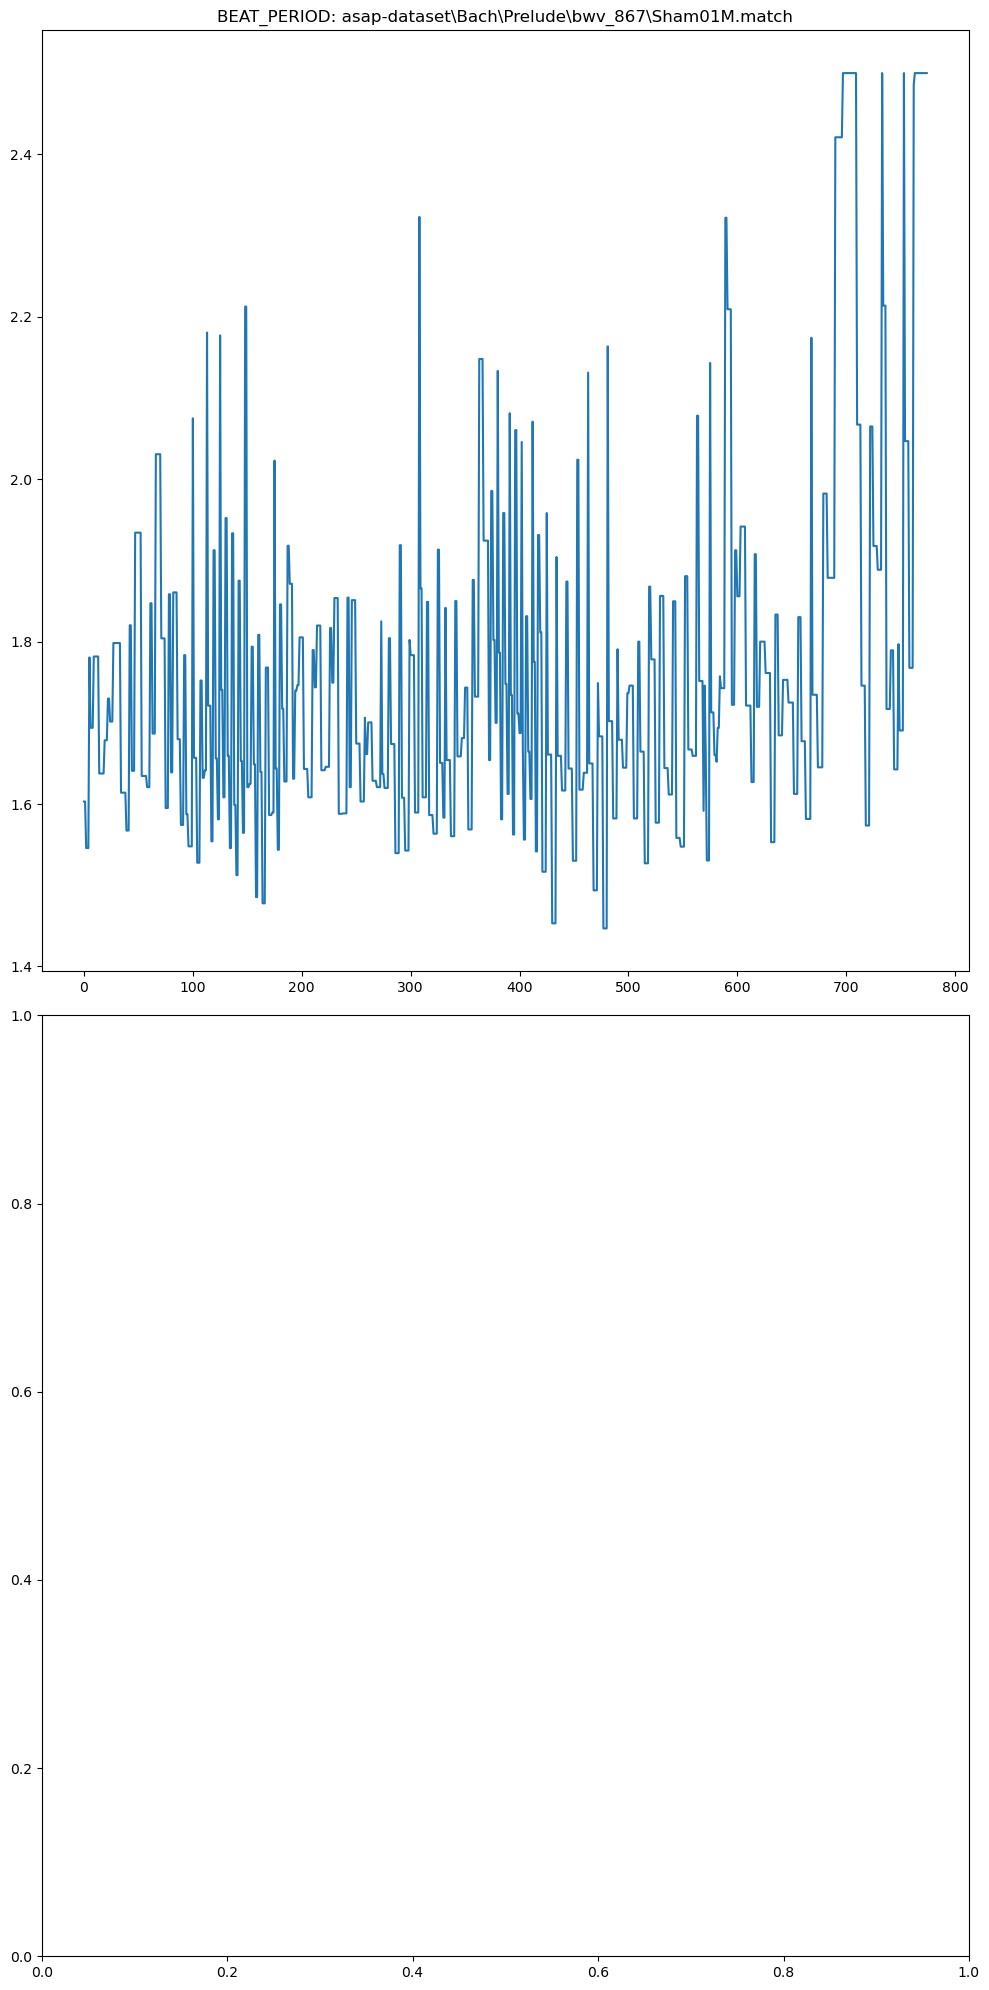

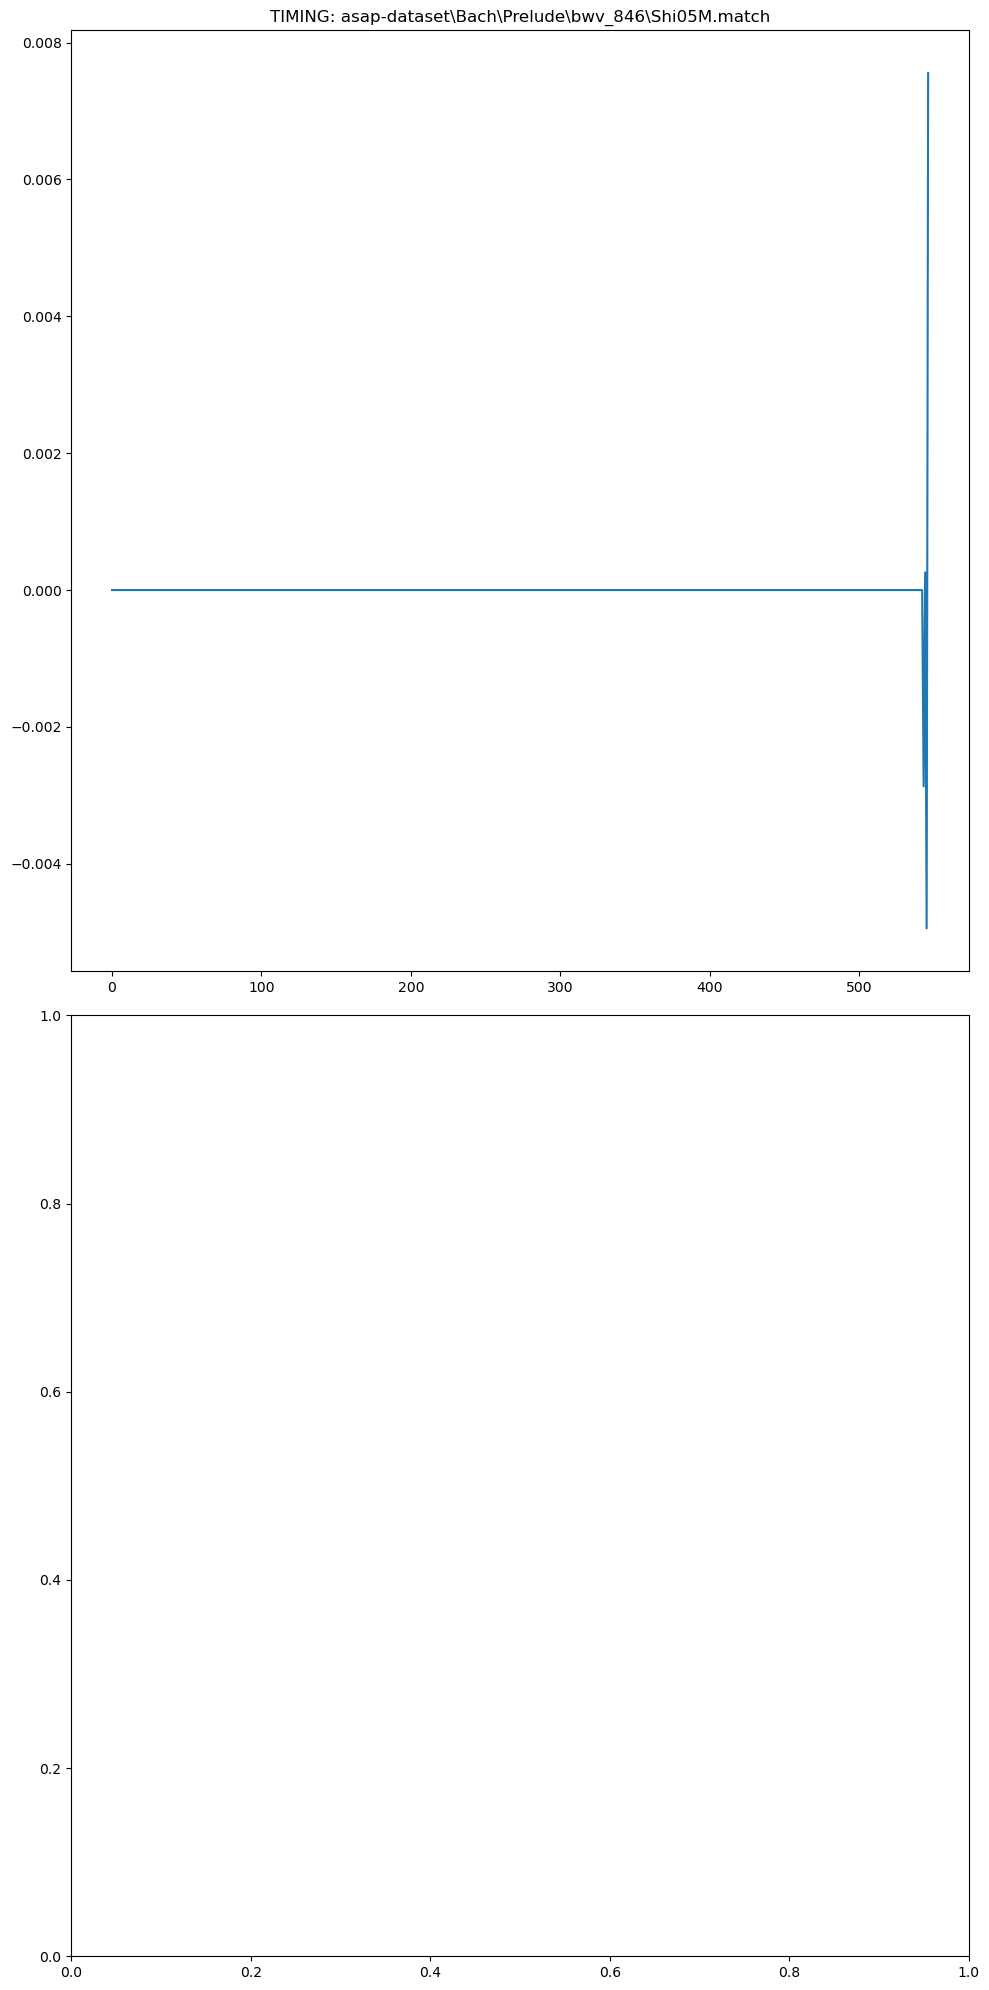

In [8]:
from matplotlib import pyplot as plt

for param_name in expressiveness_params:
    
    if len(outlier_dict[param_name]) != 0:
    
        fig, ax = plt.subplots(len(outlier_dict[param_name])+1, figsize=(10, 20))
        for i, piece_name in enumerate(outlier_dict[param_name].index):

            idx = indices.index(piece_name)
            df = dataframes[idx]

            ax[i].plot(df[param_name])
            ax[i].set(title=f"{param_name.upper()}: {piece_name}")

        fig.tight_layout()

In [9]:
valid_perf_params = [perf for perf in perf_parameters if perf[1] not in outlier_dict["piece_names"]]

print(len(perf_parameters), len(valid_perf_params))

1062 1060


## Eliminating unnecessary features <a class="anchor" id="features"></a>

In [10]:
all_feature_names

{'articulation_direction_feature.accent',
 'articulation_direction_feature.marcato',
 'articulation_direction_feature.staccato',
 'articulation_direction_feature.tenuto',
 'articulation_direction_feature.unknown_articulation',
 'articulation_feature.accent',
 'articulation_feature.breath-mark',
 'articulation_feature.caesura',
 'articulation_feature.detached-legato',
 'articulation_feature.doit',
 'articulation_feature.falloff',
 'articulation_feature.plop',
 'articulation_feature.scoop',
 'articulation_feature.soft-accent',
 'articulation_feature.spiccato',
 'articulation_feature.staccatissimo',
 'articulation_feature.staccato',
 'articulation_feature.stress',
 'articulation_feature.strong-accent',
 'articulation_feature.tenuto',
 'articulation_feature.unstress',
 'duration_feature.duration',
 'fermata_feature.fermata',
 'grace_feature.grace_note',
 'grace_feature.grace_pos',
 'grace_feature.n_grace',
 'loudness_direction_feature.f',
 'loudness_direction_feature.ff',
 'loudness_direct

In [11]:
basis_list = []
feature_names = None

counter = 0
for perf, perf_name in tqdm(valid_perf_params):
    
    xml = glob.glob(os.path.join(os.path.dirname(perf_name), "*.musicxml"))[0]
    
    score = pt.load_score(xml)
    score = pt.score.merge_parts(score)
    score = pt.score.unfold_part_maximal(score, update_ids=True)
    pt.score.expand_grace_notes(score)

    basis, bf_names = pt.musicanalysis.make_note_feats(score, "all", force_fixed_size=True)
    basis = np.mean(basis, axis=0)
    basis_list.append(basis)
    
    feature_names = bf_names

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1060/1060 [2:02:32<00:00,  6.94s/it]


In [12]:
df = pd.DataFrame(np.vstack(basis_list), columns=bf_names)
df.corr()

,articulation_direction_feature.staccato,articulation_direction_feature.tenuto,articulation_direction_feature.accent,articulation_direction_feature.marcato,articulation_direction_feature.unknown_articulation,articulation_feature.accent,articulation_feature.strong-accent,articulation_feature.staccato,articulation_feature.tenuto,articulation_feature.detached-legato,...,tempo_direction_feature.prestissimo,tempo_direction_feature.unknown_constant,tempo_direction_feature.tempo_incr,tempo_direction_feature.tempo_decr,vertical_neighbor_feature.n_total,vertical_neighbor_feature.n_above,vertical_neighbor_feature.n_below,vertical_neighbor_feature.highest_pitch,vertical_neighbor_feature.lowest_pitch,vertical_neighbor_feature.pitch_range
articulation_direction_feature.staccato,1.000000,NaN,NaN,NaN,-0.042823,0.026241,0.488199,0.384361,0.091943,0.515026,...,0.074753,0.024992,-0.041514,-0.008565,0.123231,0.110428,0.110428,0.331947,0.240842,0.083399
articulation_direction_feature.tenuto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.accent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.marcato,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
articulation_direction_feature.unknown_articulation,-0.042823,NaN,NaN,NaN,1.000000,-0.040355,-0.032106,-0.016970,-0.041402,-0.043575,...,-0.023377,0.057885,-0.050251,-0.032928,0.028280,0.025649,0.025649,0.020903,-0.069695,0.094520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vertical_neighbor_feature.n_above,0.110428,NaN,NaN,NaN,0.025649,0.115459,0.251344,0.259505,0.193584,0.061113,...,0.050438,0.308559,0.310479,0.245693,0.998384,1.000000,1.000000,0.371602,-0.428919,0.828172
vertical_neighbor_feature.n_below,0.110428,NaN,NaN,NaN,0.025649,0.115459,0.251344,0.259505,0.193584,0.061113,...,0.050438,0.308559,0.310479,0.245693,0.998384,1.000000,1.000000,0.371602,-0.428919,0.828172
vertical_neighbor_feature.highest_pitch,0.331947,NaN,NaN,NaN,0.020903,0.156903,0.510251,0.307147,0.047092,0.504432,...,0.033390,0.018322,0.141748,-0.051551,0.371358,0.371602,0.371602,1.000000,0.532121,0.454709
vertical_neighbor_feature.lowest_pitch,0.240842,NaN,NaN,NaN,-0.069695,-0.039769,0.306971,0.121176,0.022680,0.427047,...,0.024666,-0.225643,-0.161107,-0.223914,-0.421129,-0.428919,-0.428919,0.532121,1.000000,-0.512117


In [13]:
corr_matrix = df.corr().fillna(0)
drop_cols = []

for j, col in enumerate(corr_matrix.columns):
    
    if j == 0:
        i = np.argmax(np.abs(corr_matrix[col][1:]))
        corr = corr_matrix[col][i]
    else:
        i = np.argmax(np.abs(corr_matrix[col][:j:]))
        corr = corr_matrix[col][i]
        
    
    if abs(corr) > 0.85 or corr == 0:
        drop_cols.append(col)
    
    print(f"{col} has the highest correlation with {corr_matrix.index[i]}: {corr}\n")

articulation_direction_feature.staccato has the highest correlation with articulation_feature.tenuto: 0.09194342109307843

articulation_direction_feature.tenuto has the highest correlation with articulation_direction_feature.staccato: 0.0

articulation_direction_feature.accent has the highest correlation with articulation_direction_feature.staccato: 0.0

articulation_direction_feature.marcato has the highest correlation with articulation_direction_feature.staccato: 0.0

articulation_direction_feature.unknown_articulation has the highest correlation with articulation_direction_feature.staccato: -0.04282324503220027

articulation_feature.accent has the highest correlation with articulation_direction_feature.unknown_articulation: -0.04035464392974266

articulation_feature.strong-accent has the highest correlation with articulation_direction_feature.staccato: 0.488198596729276

articulation_feature.staccato has the highest correlation with articulation_feature.strong-accent: 0.430218240265

In [14]:
new_df = df.drop(columns=drop_cols)
len(new_df.columns)

new_features = list(new_df.columns)

In [15]:
new_features

['articulation_direction_feature.staccato',
 'articulation_direction_feature.unknown_articulation',
 'articulation_feature.accent',
 'articulation_feature.strong-accent',
 'articulation_feature.staccato',
 'articulation_feature.tenuto',
 'articulation_feature.detached-legato',
 'articulation_feature.staccatissimo',
 'articulation_feature.caesura',
 'duration_feature.duration',
 'fermata_feature.fermata',
 'grace_feature.grace_note',
 'grace_feature.n_grace',
 'loudness_direction_feature.ppp',
 'loudness_direction_feature.pp',
 'loudness_direction_feature.p',
 'loudness_direction_feature.mp',
 'loudness_direction_feature.mf',
 'loudness_direction_feature.f',
 'loudness_direction_feature.ff',
 'loudness_direction_feature.fff',
 'loudness_direction_feature.unknown_constant',
 'loudness_direction_feature.fp',
 'loudness_direction_feature.sf',
 'loudness_direction_feature.sfp',
 'loudness_direction_feature.sfz',
 'loudness_direction_feature.unknown_impulsive',
 'loudness_direction_feature.l

<Axes: >

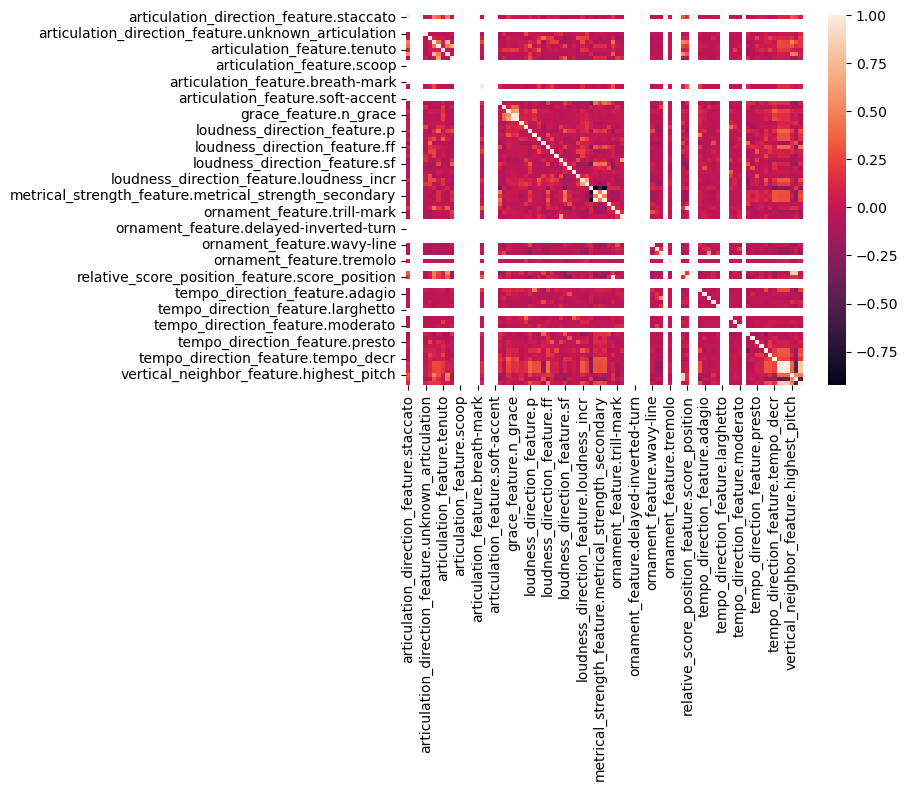

In [16]:
import seaborn as sns

sns.heatmap(df.corr())

<Axes: >

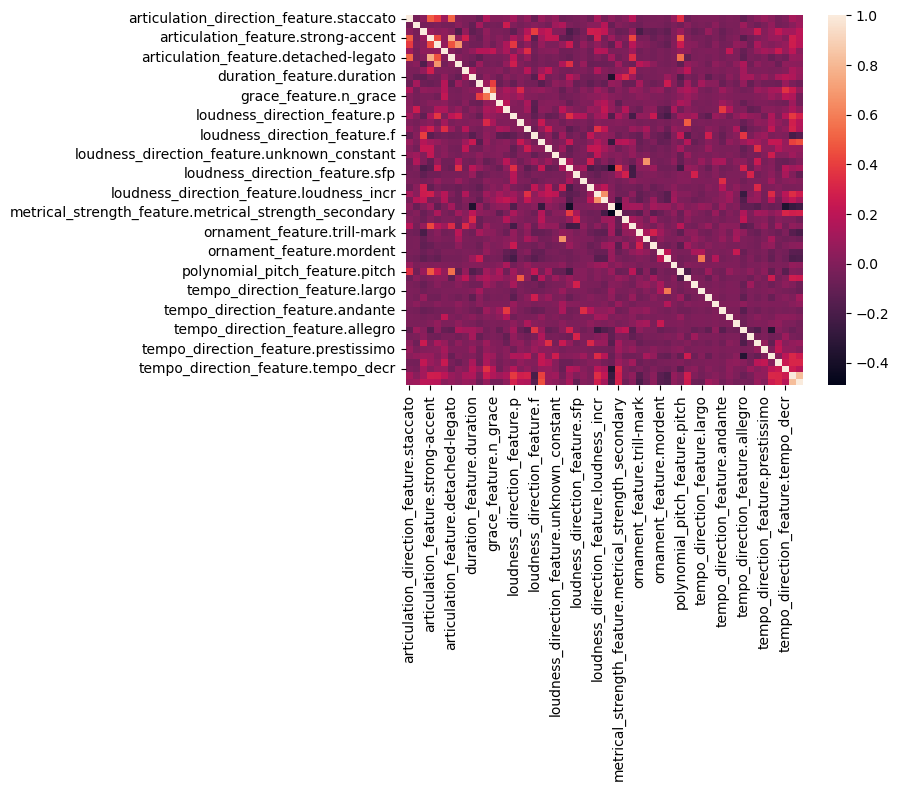

In [17]:
sns.heatmap(new_df.corr())

In [18]:
with open("better_features.txt", "w") as f:
    for feat in new_features:
        f.write(feat + "\n")

In [19]:
drop_cols = None

with open("drop_feats.txt") as f:
    drop_cols = f.read().splitlines()

drop_cols

['articulation_direction_feature.tenuto',
 'articulation_direction_feature.accent',
 'articulation_direction_feature.marcato',
 'articulation_feature.spiccato',
 'articulation_feature.scoop',
 'articulation_feature.plop',
 'articulation_feature.doit',
 'articulation_feature.falloff',
 'articulation_feature.breath-mark',
 'articulation_feature.stress',
 'articulation_feature.unstress',
 'articulation_feature.soft-accent',
 'grace_feature.grace_pos',
 'metrical_strength_feature.metrical_strength_downbeat',
 'metrical_strength_feature.metrical_strength_weak',
 'ornament_feature.delayed-turn',
 'ornament_feature.inverted-turn',
 'ornament_feature.delayed-inverted-turn',
 'ornament_feature.vertical-turn',
 'ornament_feature.inverted-vertical-turn',
 'ornament_feature.shake',
 'ornament_feature.schleifer',
 'ornament_feature.haydn',
 'ornament_feature.other-ornament',
 'relative_score_position_feature.score_position',
 'slur_feature.slur_incr',
 'slur_feature.slur_decr',
 'tempo_direction_fe

In [20]:
with open("better_features.txt", "r") as f:
    new_features = f.read().splitlines()
    
new_features

['articulation_direction_feature.staccato',
 'articulation_direction_feature.unknown_articulation',
 'articulation_feature.accent',
 'articulation_feature.strong-accent',
 'articulation_feature.staccato',
 'articulation_feature.tenuto',
 'articulation_feature.detached-legato',
 'articulation_feature.staccatissimo',
 'articulation_feature.caesura',
 'duration_feature.duration',
 'fermata_feature.fermata',
 'grace_feature.grace_note',
 'grace_feature.n_grace',
 'loudness_direction_feature.ppp',
 'loudness_direction_feature.pp',
 'loudness_direction_feature.p',
 'loudness_direction_feature.mp',
 'loudness_direction_feature.mf',
 'loudness_direction_feature.f',
 'loudness_direction_feature.ff',
 'loudness_direction_feature.fff',
 'loudness_direction_feature.unknown_constant',
 'loudness_direction_feature.fp',
 'loudness_direction_feature.sf',
 'loudness_direction_feature.sfp',
 'loudness_direction_feature.sfz',
 'loudness_direction_feature.unknown_impulsive',
 'loudness_direction_feature.l

## Building a dataset <a class="anchor" id="datasets"></a>

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    
    def __init__(self,
                 match_paths,
                 seq_len, param_names=["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"],
                 fixed_features=True,
                 feat_names="all",
                 drop_feats=[]
                ):   
        
        self.data = []
        self.target_data = None
        self.param_names = param_names
        self.parameter_dict = {name: [] for name in param_names}
        
        self.feature_size = 0
        self.seq_len = seq_len
        
        print("Processing score data...")
        for match_file in tqdm(match_paths):
            
            try:
                
                xml = glob.glob(os.path.join(os.path.dirname(match_file), "*.musicxml"))[0]

                score = pt.load_score(xml)
                score = pt.score.merge_parts(score)
                score = pt.score.unfold_part_maximal(score, update_ids=True)

                nid_dict = dict((n.id, i) for i, n in enumerate(score.notes_tied))

                pt.score.expand_grace_notes(score)

                basis, bf_names = pt.musicanalysis.make_note_feats(score, feat_names, force_fixed_size=fixed_features)

                performance, alignment = pt.load_match(match_file)

                parameter_names = param_names

                pc = get_performance_codec(parameter_names)

                targets, snote_ids, unique_onset_idxs = pc.encode(
                    part=score,
                    ppart=performance[0],
                    alignment=alignment,
                    return_u_onset_idx=True
                )

                matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
                basis_matched = basis[matched_subset_idxs]
                
                basis_matched = pd.DataFrame(basis_matched, columns=bf_names)
                basis_matched = basis_matched.drop(columns=drop_feats).to_numpy()
                
                # clipping outliers
                
                np.clip(targets["beat_period"], a_min=0, a_max=3, out=targets["beat_period"])
                np.clip(targets["timing"], a_min=-1, a_max=1, out=targets["timing"])
                
            except Exception as e:
                print(match_file)
                print(e)
                continue
            
            padding_len = len(targets) % seq_len
            
            for name in param_names:
                new_targets = targets[name]
                t_padding_array = np.zeros(shape=seq_len - padding_len)
                new_targets = np.concatenate((new_targets, t_padding_array))
                new_targets = np.split(new_targets, len(new_targets) / seq_len)
                
                self.parameter_dict[name] += [target for target in new_targets]
            
            bm_padding_array = np.zeros(shape=(seq_len - padding_len, basis_matched.shape[1]))
            new_basis = np.vstack((basis_matched, bm_padding_array))
            new_basis = np.split(new_basis, len(new_basis) / seq_len)
            
            self.data += [basis for basis in new_basis]
            
        max_features = max([basis.shape[1] for basis in self.data])
        self.feature_size = max_features
        
        for i, basis in enumerate(self.data):
            if basis.shape[1] < max_features:
                
                difference = max_features - basis.shape[1]
                
                self.data[i] = np.hstack((basis, np.zeros(shape=(seq_len, difference))))
            
    def choose_parameter(self, parameter_name):
        self.target_data = self.parameter_dict[parameter_name]
        
    def __getitem__(self, idx):
        
        x = self.data[idx]
        y = self.target_data[idx]
        
        if y is None:
            raise ValueError("Use self.choose_parameter() to choose target parameter first")
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [29]:
all_matches = glob.glob(os.path.join("asap-dataset", "**", "*.match"), recursive=True)
all_matches = [match for match in all_matches if match not in outlier_dict["piece_names"]]

rng = np.random.default_rng()
all_indices = list(range(len(all_matches)))
rng.shuffle(all_indices)

test_indices = all_indices[:int(len(all_indices) * 0.2)]
val_indices = all_indices[int(len(all_indices) * 0.2):int(len(all_indices) * 0.3)]
train_indices = all_indices[int(len(all_indices) * 0.3):]
print(len(test_indices), len(val_indices), len(train_indices))

test_set = MyDataset([all_matches[i] for i in test_indices], seq_len=50, drop_feats=drop_cols)
val_set = MyDataset([all_matches[i] for i in val_indices], seq_len=50, drop_feats=drop_cols)
train_set = MyDataset([all_matches[i] for i in train_indices], seq_len=50, drop_feats=drop_cols)

212 106 742
Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [12:17<00:00,  3.48s/it]


Processing score data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [06:52<00:00,  3.89s/it]


Processing score data...


 67%|██████████████████████████████████████████████████████████████████████████████                                      | 499/742 [47:45<10:14,  2.53s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4551,4599,4599,68). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13397,13467,13596,74). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 523/742 [48:57<14:50,  4.07s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,4513,4540,4540,64). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n166,[B,b],4,13799,13860,14020,70). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 723/742 [1:09:43<00:51,  2.71s/it]

snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n55-1,[B,b],3,6:1,1/10,-1/28,8.388671875,8.25,[])-note(n48,[B,b],3,6552,6591,6591,69). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-note(n165,[B,b],4,15133,15167,15296,80). -1/28 cannot be interpreted as FractionalSymbolicDuration Version(major=0, minor=5, patch=0)
snote(n178-1,[B,b],4,16:1,1/10,-1/28,28.388671875,28.25,[])-no

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 742/742 [1:12:45<00:00,  5.88s/it]


In [30]:
torch.save(test_set, "test_set.pt")
torch.save(val_set, "validation_set.pt")
torch.save(train_set, "train_set.pt")

In [32]:
test_set.feature_size, val_set.feature_size, train_set.feature_size

(57, 57, 57)

## Defining models <a class="anchor" id="models"></a>

In [33]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        
        self.model_name = "LSTM"
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [34]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).to(x.dtype)
        
        # Forward propagate LSTM
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [35]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMSeq2Seq, self).__init__()
        
        self.model_name = "Seq2SeqLSTM"
        
        output_size = 1

        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, src):
        batch_size = src.size(0)

        # Encoder
        encoder_output, (hidden, cell) = self.encoder(src)

        # Decoder initialization with encoder's last hidden and cell state
        decoder_input = torch.zeros(batch_size, 1, self.hidden_size).to(src.device)

        outputs = []
        for i in range(encoder_output.size(1)):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            output = self.output_layer(decoder_output)
            outputs.append(output)
            decoder_input = decoder_output

        return torch.cat(outputs, dim=1)

In [36]:
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_heads=3, hidden_size=2048, num_layers=10, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.model_name = "Transformer"
        
        # Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)

        # Decoder
        self.decoder = nn.Linear(input_size * output_size, output_size)

    def forward(self, src):
        # Encoding
        enc_output = self.transformer_encoder(src)
        enc_output = enc_output.view(src.shape[0], -1)

        # Decoding
        dec_output = self.decoder(enc_output)  # Use the last encoder output for prediction
        return dec_output

In [37]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=2048, num_layers=10):
        super(Net, self).__init__()
        
        self.model_name = "BasicNN"
        
        hidden_layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        
        for i in range(num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            hidden_layers.append(nn.ReLU())
            
        self.fc = nn.Sequential(*hidden_layers)
        
        self.out = nn.Linear(hidden_size * output_size, output_size)

    def forward(self, x):
        
        x = self.fc(x)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        
        return x

## Training and evaluation <a class="anchor" id="training"></a>

device=cpu


Training model for beat_period



KeyboardInterrupt: 

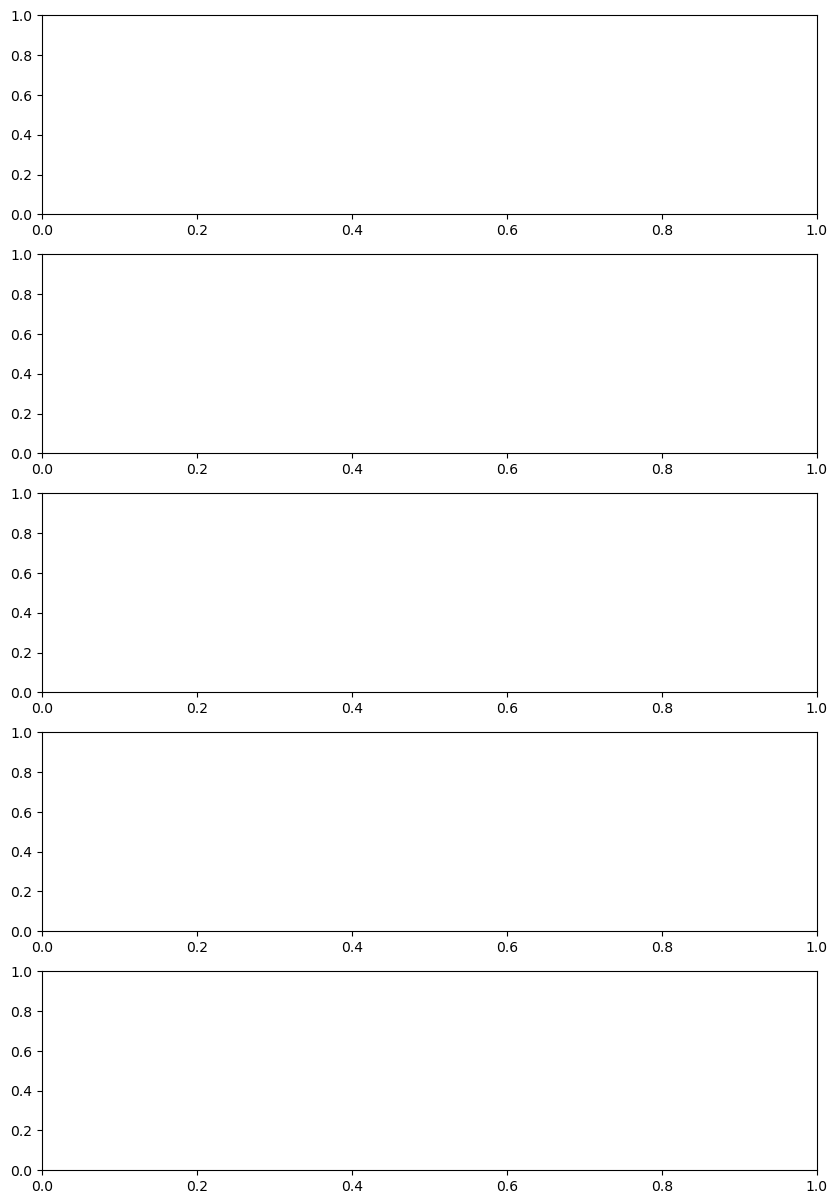

In [41]:
NUM_EPOCHS = 100
NUM_LAYERS = 2
HIDDEN_SIZE = 1024

# writer = SummaryWriter()
# writer.flush()

models = []
param_names = ["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]
fig, ax = plt.subplots(5, figsize=(10, 15))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"device={device}\n\n")

# train model for each parameter
for i, name in enumerate(param_names):
    
    print(f"Training model for {name}\n")
    
    # initialize model and dataloaders
    my_model = LSTMSeq2Seq(input_size=train_set.feature_size,
                   hidden_size=HIDDEN_SIZE,
                   output_size=train_set.seq_len
                  )
    
    my_model.to(device)
    
    train_set.choose_parameter(name)
    test_set.choose_parameter(name)
    val_set.choose_parameter(name)

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    learning_rate = 1e-4
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)

    # Training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    my_model.to(device)

    train_losses = []
    val_losses = [np.inf]
    best_model = None
    best_val_loss = np.inf

    # Train/Validation loop
    for epoch in range(NUM_EPOCHS):

        # Training
        total_train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()
            
            # Forward pass
            outputs = my_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())  # Assuming the output and target shapes are compatible

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validating
        total_val_loss = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.float(), targets.float()

            # Forward pass
            outputs = my_model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())

            total_val_loss += loss.item()

        if total_val_loss / len(val_loader) < best_val_loss:
            best_model = my_model.state_dict()

        if len(val_losses) > 10 and min(val_losses) not in val_losses[-10:]:
            print("Validation loss is increasing, stopping early...")
            break

        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Average train Loss: {total_train_loss / len(train_loader):.4f}, Average validation Loss: {total_val_loss / len(val_loader):.4f}")
        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))
        
        """writer.add_scalars(f"Train loss vs. validation loss {name} ({my_model.model_name})", {"train loss": total_train_loss / len(train_loader),
                                                                      "val loss": total_val_loss / len(val_loader)}, epoch)"""
        

    print("Training finished\n")
    torch.save(best_model, os.path.join("models", f"{my_model.model_name}_best_model_{name}.pt"))

    # Testing
    my_model.load_state_dict(best_model)
    
    total_test_loss = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()

        # Forward pass
        outputs = my_model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        total_test_loss += loss.item()

    print(f"Average loss on test set: {total_test_loss / len(test_loader)}\n\n")
    models.append(my_model)
    
    # writer.add_graph(my_model, input_to_model=inputs)
    
    ax[i].plot(train_losses)
    ax[i].plot(val_losses)
    
fig.tight_layout()
# writer.close()

In [14]:
torch.save(best_model, os.path.join("models", f"{my_model.model_name}_best_model_{name}.pt"))

In [31]:
def sequence_piece(
    seq_len,
    match_file,
    feats="all",
    param_names=["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]):
        
    parameter_dict = {name: [] for name in param_names}
    data = []
    
    xml = glob.glob(os.path.join(os.path.dirname(match_file), "*.musicxml"))[0]

    score = pt.load_score(xml)
    score = pt.score.merge_parts(score)
    score = pt.score.unfold_part_maximal(score, update_ids=True)

    nid_dict = dict((n.id, i) for i, n in enumerate(score.notes_tied))

    pt.score.expand_grace_notes(score)

    basis, bf_names = pt.musicanalysis.make_note_feats(score, feats, force_fixed_size=True)

    performance, alignment = pt.load_match(match_file)

    parameter_names = param_names

    pc = get_performance_codec(parameter_names)

    targets, snote_ids, unique_onset_idxs = pc.encode(
        part=score,
        ppart=performance[0],
        alignment=alignment,
        return_u_onset_idx=True
    )
    
    matched_subset_idxs = np.array([nid_dict[nid] for nid in snote_ids])
    basis_matched = basis[matched_subset_idxs]

    # clipping outliers

    np.clip(targets["beat_period"], a_min=0, a_max=3, out=targets["beat_period"])
    np.clip(targets["timing"], a_min=-1, a_max=1, out=targets["timing"])
    
    padding_len = len(targets) % seq_len
            
    for name in param_names:
        new_targets = targets[name]
        t_padding_array = np.zeros(shape=seq_len - padding_len)
        new_targets = np.concatenate((new_targets, t_padding_array))
        new_targets = np.split(new_targets, len(new_targets) / seq_len)

        parameter_dict[name] += [target for target in new_targets]

    bm_padding_array = np.zeros(shape=(seq_len - padding_len, basis_matched.shape[1]))
    new_basis = np.vstack((basis_matched, bm_padding_array))
    new_basis = np.split(new_basis, len(new_basis) / seq_len)

    data += [basis for basis in new_basis]
    
    unsequenced_data = basis_matched
    unsequenced_targets = targets
    
    return data, parameter_dict, unsequenced_data, unsequenced_targets

In [32]:
match = glob.glob(os.path.join("asap-dataset", "Bach", "Fugue", "bwv_846", "*.match"))[0]

bfs, target_dict, unsequenced_data, unsequenced_targets = sequence_piece(50, match)

dict_keys(['beat_period', 'timing', 'articulation_log', 'velocity_trend', 'velocity_dev'])

In [29]:
device = "cuda"
models = []

HIDDEN_SIZE = 1024
param_names=["beat_period", "timing", "articulation_log", "velocity_trend", "velocity_dev"]


preds = {name: [] for name in param_names}
ground_truths = {name: [] for name in param_names}

for name in param_names:
    
    model = LSTMSeq2Seq(input_size=custom_dataset.feature_size, output_size=custom_dataset.seq_len, hidden_size=HIDDEN_SIZE)
    model.load_state_dict(torch.load(f"models\\{model.model_name}_best_model_{name}.pt"))
    
    custom_dataset.choose_parameter(name)
    
    new_dataset = Subset(custom_dataset, list(range(20)))
    new_dataloader = DataLoader(new_dataset, shuffle=False, batch_size=1)

    for inputs, targets in new_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        
        model.to(device)
        outputs = model(inputs)

        preds[name] += outputs.tolist()[0]

zipped_list = [(a[0], b[0], c[0], d[0], e[0]) for a, b, c, d, e in zip(preds["beat_period"], preds["timing"], preds["articulation_log"], preds["velocity_trend"], preds["velocity_dev"])]

In [30]:
zipped_list

[(1.1504333019256592,
  -0.0035139014944434166,
  0.03135836869478226,
  0.2931748628616333,
  -0.02150632254779339),
 (1.239532470703125,
  -0.010278783738613129,
  -0.1487477421760559,
  0.3704894185066223,
  0.008148817345499992),
 (1.2027384042739868,
  -0.009796366095542908,
  -0.0582292303442955,
  0.40801578760147095,
  0.00392516702413559),
 (1.206260323524475,
  -0.00675448402762413,
  -0.09896814078092575,
  0.4147978127002716,
  0.00529678538441658),
 (1.1989164352416992,
  -0.0064034052193164825,
  -0.18415385484695435,
  0.4378940165042877,
  -0.0015609357506036758),
 (1.193464756011963,
  -0.007073214277625084,
  -0.2849903702735901,
  0.4304386079311371,
  0.0024928804486989975),
 (1.1714627742767334,
  -0.007942967116832733,
  -0.29846471548080444,
  0.4198529124259949,
  0.01404174230992794),
 (1.1561315059661865,
  -0.00849432498216629,
  -0.25529783964157104,
  0.40616658329963684,
  0.00453531090170145),
 (1.1429767608642578,
  -0.008698021993041039,
  -0.2246567010

In [31]:
test_perf = np.array(zipped_list, dtype=perf_parameters[0][0].dtype)
test_perf["beat_period"] = np.abs(test_perf["beat_period"])
test_perf["velocity_trend"] = np.abs(test_perf["velocity_trend"])
test_perf["velocity_dev"] = np.abs(test_perf["velocity_dev"])

In [32]:
xml = glob.glob(os.path.join("asap-dataset", "Bach", "Fugue", "bwv_846", "*.musicxml"))[0]

score = pt.load_score(xml)
score = pt.score.merge_parts(score)
score = pt.score.unfold_part_maximal(score, update_ids=True)
pt.score.expand_grace_notes(score)

pc = get_performance_codec(param_names)

result = pc.decode(score, test_perf)

In [33]:
test_perf

array([(1.1504333 , -0.0035139 ,  3.13583687e-02, 2.9317486e-01, 2.15063225e-02),
       (1.2395325 , -0.01027878, -1.48747742e-01, 3.7048942e-01, 8.14881735e-03),
       (1.2027384 , -0.00979637, -5.82292303e-02, 4.0801579e-01, 3.92516702e-03),
       (1.2062603 , -0.00675448, -9.89681408e-02, 4.1479781e-01, 5.29678538e-03),
       (1.1989164 , -0.00640341, -1.84153855e-01, 4.3789402e-01, 1.56093575e-03),
       (1.1934648 , -0.00707321, -2.84990370e-01, 4.3043861e-01, 2.49288045e-03),
       (1.1714628 , -0.00794297, -2.98464715e-01, 4.1985291e-01, 1.40417423e-02),
       (1.1561315 , -0.00849432, -2.55297840e-01, 4.0616658e-01, 4.53531090e-03),
       (1.1429768 , -0.00869802, -2.24656701e-01, 3.9678261e-01, 6.47360459e-04),
       (1.1401232 , -0.00869602, -2.33002663e-01, 3.9129749e-01, 4.57294285e-04),
       (1.141387  , -0.00862958, -2.60862797e-01, 3.9107326e-01, 5.44103328e-03),
       (1.1490014 , -0.00857069, -2.92179674e-01, 3.9521119e-01, 1.41951349e-02),
       (1.159297

In [34]:
pt.save_performance_midi(result, "test_midi.mid")

In [35]:
def plot_rendering(name):
    custom_dataset.choose_parameter(name)

    new_dataset = Subset(custom_dataset, list(range(20)))
    new_dataloader = DataLoader(new_dataset, shuffle=False, batch_size=1)

    ground_truths = []

    for inputs, targets in new_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()

        ground_truths += targets.tolist()[0]

    plt.plot(ground_truths)
    plt.plot(test_perf[name])

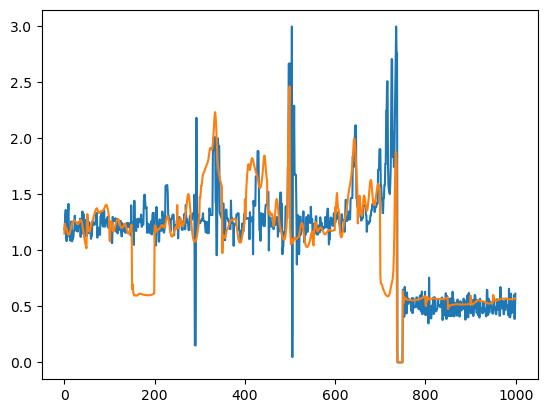

In [36]:
plot_rendering("beat_period")

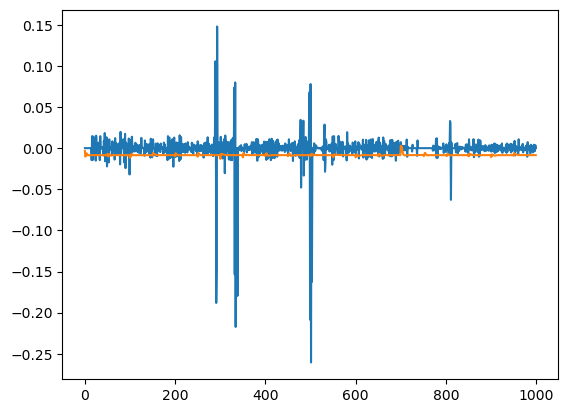

In [37]:
plot_rendering("timing")

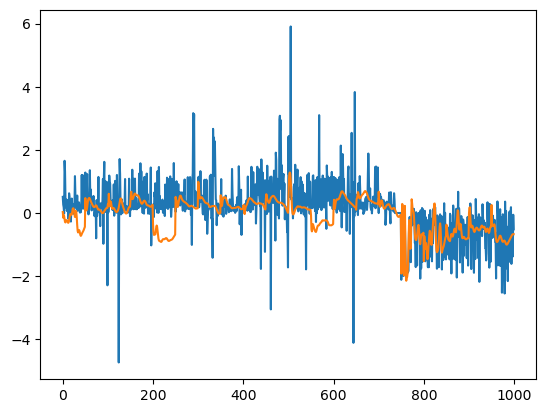

In [38]:
plot_rendering("articulation_log")

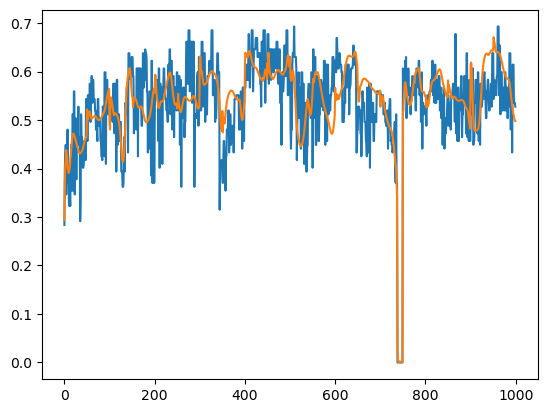

In [39]:
plot_rendering("velocity_trend")

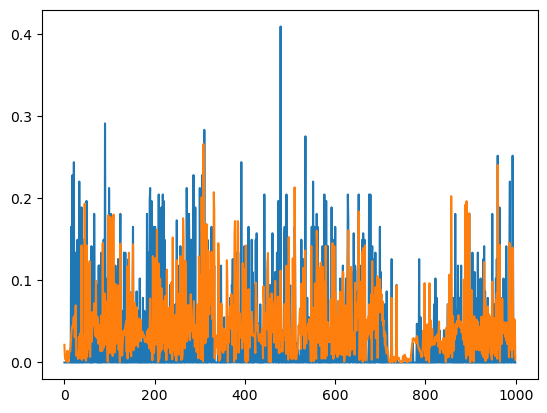

In [40]:
plot_rendering("velocity_dev")